# Bank Churn Prediction

Why Customer retention is important? [source](https://www.dcrstrategies.com/customer-incentives/5-reasons-customer-retention-business/)

    1. Save Money On Marketing
    2. Repeat Purchases From Repeat Customers Means Repeat Profit
    3. Free Word-Of-Mouth Advertising
    4. Retained Customers Will Provide Valuable Feedback
    5. Previous Customers Will Pay Premium Prices. 

Why and when will a customer leave his/her bank could be a challenging question to answer.

Here, we have a data from kaggle where all the historical information about a customer and whether he/she left the bank or not is available.

Our goal is to use the power of data science to help the bank identify those who are likely to leave the bank in future.


# Load Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Read Data

In [4]:
# source - https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers
bank_data = pd.read_csv('Churn_Modelling.csv')
bank_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
# Dimensions
print("Number of Rows: {} \nNumber of Columns: {}".format(bank_data.shape[0],bank_data.shape[1]))

Number of Rows: 10000 
Number of Columns: 14


In [6]:
# data types, missing values and number of uniques
bank_data_info = pd.concat([pd.DataFrame(bank_data.dtypes),pd.DataFrame(bank_data.isnull().sum()),pd.DataFrame(bank_data.nunique())],axis = 1)
bank_data_info.columns = ['DataType','# missing rows','# Unique values']
print(bank_data_info)
del bank_data_info


                DataType  # missing rows  # Unique values
RowNumber          int64               0            10000
CustomerId         int64               0            10000
Surname           object               0             2932
CreditScore        int64               0              460
Geography         object               0                3
Gender            object               0                2
Age                int64               0               70
Tenure             int64               0               11
Balance          float64               0             6382
NumOfProducts      int64               0                4
HasCrCard          int64               0                2
IsActiveMember     int64               0                2
EstimatedSalary  float64               0             9999
Exited             int64               0                2


The data has 10000 rows and columns. 

Let's see the data description.

# Data Description

1. RowNumber: Just a index number assigned to each row. Type : int64
2. CustomerId: Id of each customer of the bank. Type : int64
3. Surname: Surname of the customer. Type : Object
4. CreditScore: The measure of an individual's ability to payback the borrowed amount. Higher it is the better. Type : int64
5. Geography: Country of the customer. Type : Object. Values: [France, Germany, Spain]
6. Gender: Customer's gender. Type : Object. Values: [Male / Female]
7. Age: Age of the customer. Type : int64
8. Tenure: Duration for which the loan amount is sanctioned.Assuming it to be in years Type : int64
9. Balance: The amount of money the customer has available in his account. Type: int64
10. NumOfProducts: How many accounts, bank account affiliated products the person has. Type: int64
11. HasCrCard: whether the person holds a credit card or not. 1 means he/she has a credit card and 0 means he/she doesn't. Type: int64
12. IsActiveMember: Whether the customer is actively using the account. However, the values are subjective. Type: int64
13. EstimatedSalary: The person's approximate salary. Type: float64
14. Exited: Whether the customer has left the bank or not. 1 means he/she left and 0 means he/she didn't. Type: int64

From the above, we will not require RowNumber, CustomerId, and Surname are related to individuals.

In [7]:
# drop columns RowNumber, CustomerId, and Surname
bank_data.drop(["RowNumber", "CustomerId", "Surname"], axis = 1,inplace = True)
bank_data.tail()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1
9999,792,France,Female,28,4,130142.79,1,1,0,38190.78,0


# Exploratory Data Analysis (EDA)

The purpose of EDA is to understand how different variables are related to our target (Exited) variable.

In [8]:
bank_data['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [9]:
import plotly.graph_objects as go

labels = ['Exited','Continued']
values =  [bank_data.Exited[bank_data['Exited']==1].count(), bank_data.Exited[bank_data['Exited']==0].count()]
colors = ['red', 'darkorange']
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_traces(hole=.4, hoverinfo='label+value',  textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(
    title_text="Ratio of Customer Churned and Retained")
fig.show()

From the above, we can see that the data is imbalanced. Almost 80% of customers have continued while 20% churned out. We need to take this into consideration while evaluating the model's accuracy because, even if we predict all the customers to be continued, we will still end up getting 80% accuracy. Our focus should be on churn rate i.e., on the minority class - 'Exited'

### Gender 

Who stays longer? Male or Female?

In [10]:
print(bank_data[['Gender','Exited']].groupby(['Gender']).mean())
print()
print("Female - Exited: ",len(bank_data[(bank_data['Exited'] == 1) & (bank_data['Gender'] == 'Female')]))
print("Female - Retained: ",len(bank_data[(bank_data['Exited'] == 0) & (bank_data['Gender'] == 'Female')]))
print()
print("Male - Exited: ",len(bank_data[(bank_data['Exited'] == 1) & (bank_data['Gender'] == 'Male')]))
print("Male - Retained: ",len(bank_data[(bank_data['Exited'] == 0) & (bank_data['Gender'] == 'Male')]))

          Exited
Gender          
Female  0.250715
Male    0.164559

Female - Exited:  1139
Female - Retained:  3404

Male - Exited:  898
Male - Retained:  4559


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



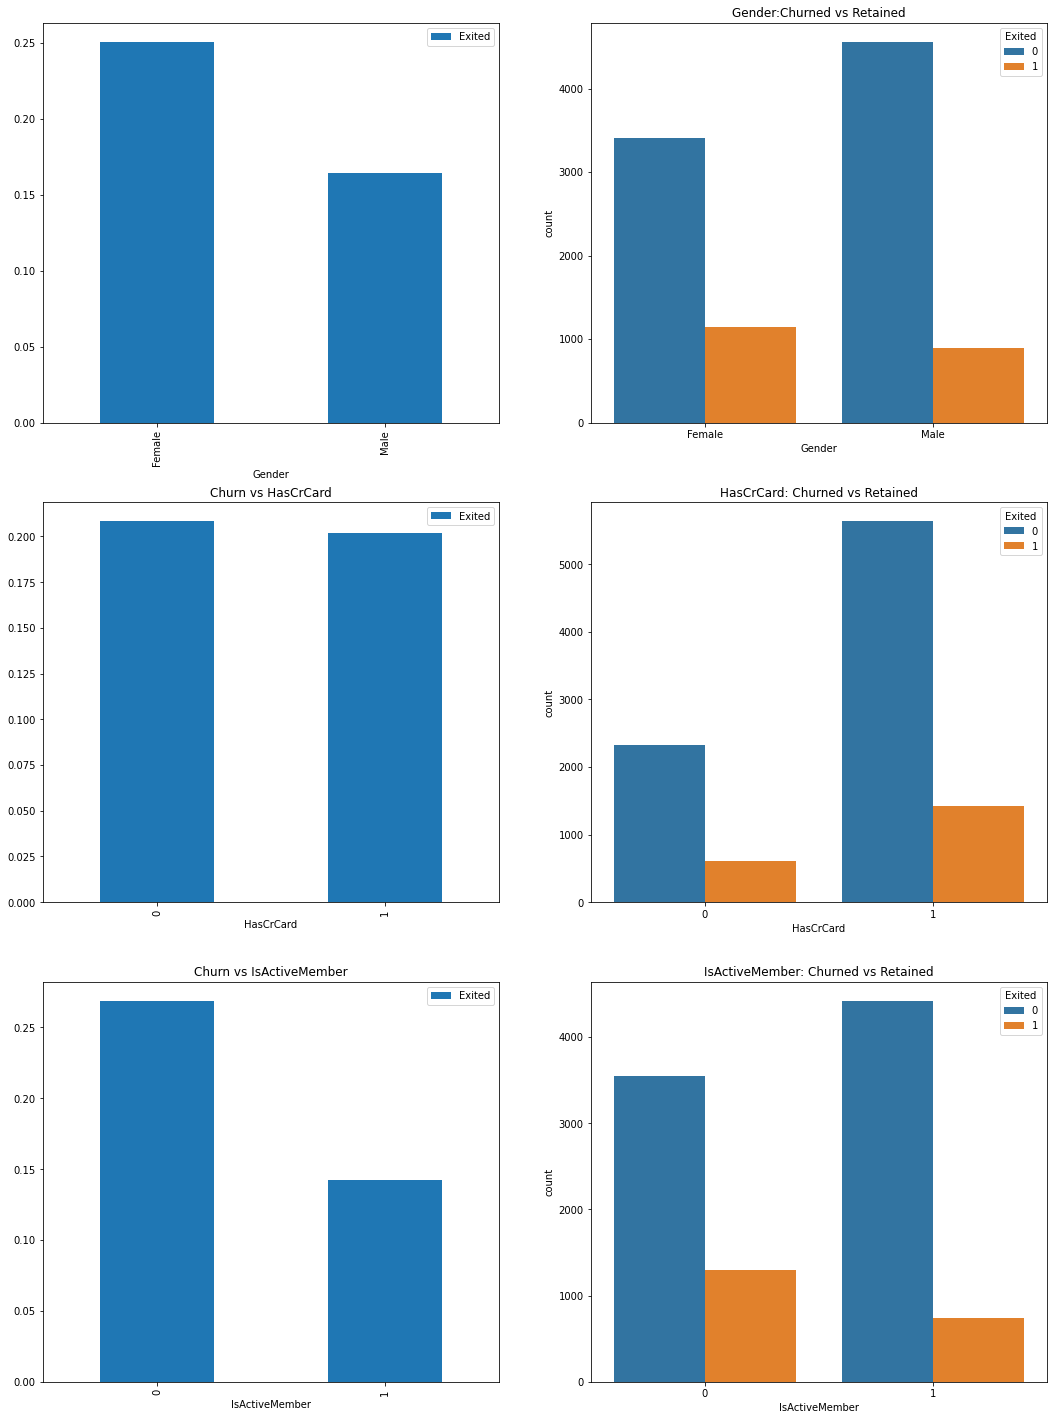

In [11]:
# Gender,HasCrCard,IsActiveMember vs Churn
f,ax=plt.subplots(3,2,figsize=(18,25))
bank_data[['Gender','Exited']].groupby(['Gender']).mean().plot.bar(ax=ax[0][0])
ax[0][1].set_title('Churn vs Gender')
sns.countplot('Gender',hue='Exited',data=bank_data,ax=ax[0][1])
ax[0][1].set_title('Gender:Churned vs Retained')
bank_data[['HasCrCard','Exited']].groupby(['HasCrCard']).mean().plot.bar(ax=ax[1][0])
ax[1][0].set_title('Churn vs HasCrCard')
sns.countplot('HasCrCard',hue='Exited',data=bank_data,ax=ax[1][1])
ax[1][1].set_title('HasCrCard: Churned vs Retained')
bank_data[['IsActiveMember','Exited']].groupby(['IsActiveMember']).mean().plot.bar(ax=ax[2][0])
ax[2][0].set_title('Churn vs IsActiveMember')
sns.countplot('IsActiveMember',hue='Exited',data=bank_data,ax=ax[2][1])
ax[2][1].set_title('IsActiveMember: Churned vs Retained')
plt.show()

From the above graphs we can see, 

1. More male customers, but when it comes to churn rate, female customers are more likely to quit the bank. (In other words, even though there are more male customers its the females who have high churn rate compared to males).
2. Majority of customers have credit cards. 
3. The bank have a significant number of inactive customers. They ratio of inactive customers being churned out is high. Thus bank needs to take steps and make them active. 

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



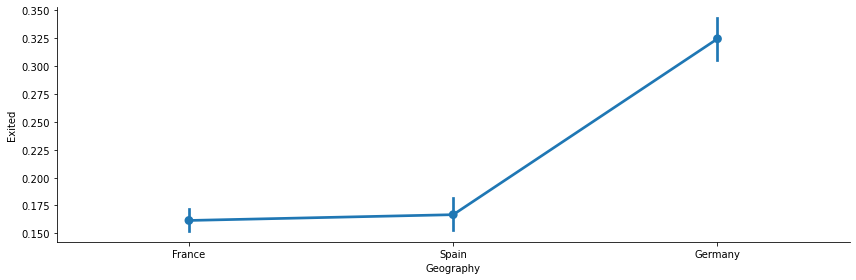

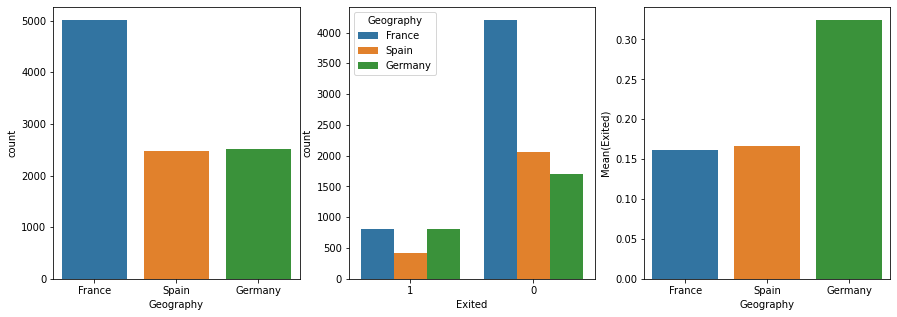

In [15]:
# Geography vs Churn
sns.factorplot(x='Geography',y='Exited', data=bank_data,height=4,aspect=3)

fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(15,5))


sns.countplot(x='Geography', data=bank_data, ax=axis1)
sns.countplot(x='Exited', hue="Geography", data=bank_data, order=[1,0], ax=axis2)

# group by Geography, and get the mean for Churned customers for each value in Geography
geography_perc = bank_data[["Geography", "Exited"]].groupby(['Geography'],as_index=False).mean()
geography_perc.columns = ['Geography', 'Mean(Exited)']
sns.barplot(x='Geography', y='Mean(Exited)', data=geography_perc,order=['France','Spain','Germany'],ax=axis3)
del geography_perc


The bank have majority of its customers located in France, however the chrun rate is high in Germany followed by spain, where the bank have less number of customers. This can be due to less number of branches in Germany and Spain or poor services in those regions. 

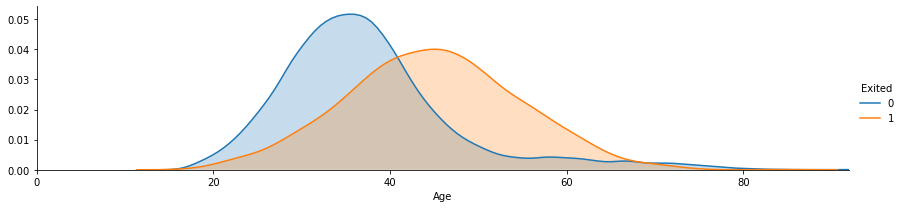

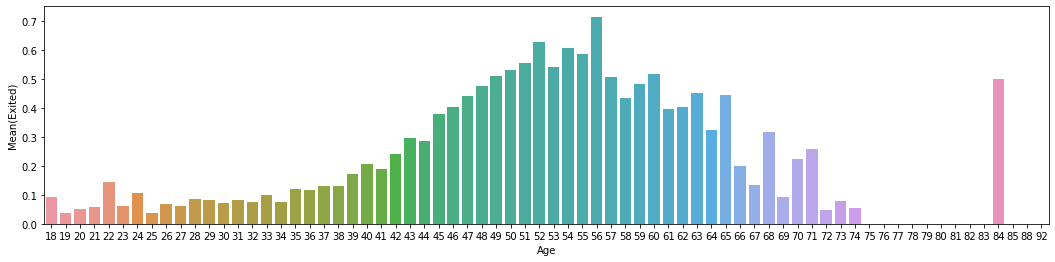

In [ ]:
# Age
# peaks for Exited/not exited customers by their age
facet = sns.FacetGrid(bank_data, hue="Exited",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, bank_data['Age'].max()))
facet.add_legend()

# average exited customers by age
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
average_age = bank_data[["Age", "Exited"]].groupby(['Age'],as_index=False).mean()
average_age.columns = ['Age','Mean(Exited)']
sns.barplot(x='Age', y='Mean(Exited)', data=average_age)
del average_age

Customer having age around 48 to 60 are churning out compared to younger ones i.e., Mean(Exited) > 0.5 from the graph. The churn rate can also be due to retirement. Bank needs to revise the market strategy by focusing on keeping older customers. 

In [ ]:
bank_data[(bank_data['Age'] == 56)]['Exited'].value_counts()

1    50
0    20
Name: Exited, dtype: int64

In [16]:
# Tenure

y0 = bank_data.Tenure[bank_data.Exited == 0].values
y1 = bank_data.Tenure[bank_data.Exited == 1].values

fig = go.Figure()
fig.add_trace(go.Box(y=y0, name='Continued',
                marker_color = 'lightseagreen'))
fig.add_trace(go.Box(y=y1, name = 'Exited',
                marker_color = 'indianred'))

fig.update_layout(
    yaxis_title='Tenure'
)

fig.show()


With respect to Tenure, Customers repaying loans in less years or taking more time to repay loans are churning out. Bank needs to provide benefits for customers who are repaying loans in quick time and for those who have stayed for a long time (High tenure). 

In [17]:
# Balance
y0 = bank_data.Balance[bank_data.Exited == 0].values
y1 = bank_data.Balance[bank_data.Exited == 1].values

fig = go.Figure()
fig.add_trace(go.Box(y=y0, name='Continued',
                marker_color = 'blue'))
fig.add_trace(go.Box(y=y1, name = 'Exited',
                marker_color = 'red'))

fig.update_layout(
    yaxis_title='Balance'
)

fig.show()

We can see that Customers having balance even after churning out.

Even though the gap is not very high yet the Customers with high account balance are churning out. This may even be due to the data imbalance. To be on the safer side the bank needs to address this as it will impact their profit. 


## Correlation check!

In [18]:
cordata = bank_data.corr(method ='pearson')
cordata.style.background_gradient(cmap='summer')

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.003965,0.000842,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,-0.003965,1.000000,-0.009997,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,0.000842,-0.009997,1.000000,-0.012254,0.013444,0.022583,-0.028362,0.007784,-0.014001
Balance,0.006268,0.028308,-0.012254,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.012238,-0.030680,0.013444,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,-0.005458,-0.011721,0.022583,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.025651,0.085472,-0.028362,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.001384,-0.007201,0.007784,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
Exited,-0.027094,0.285323,-0.014001,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


Age has some correlation (28.5%) with Churn rate. There are no real highly correlated features. NumberOfProducts and Balance are 30.4% Correlated among themselves. Apart from that there are no multi-collinear features which is good.

Let's try and create some features [feature engineering]. Let's See if we can create more useful features.

# Feature Engineering

One of the most important part in a data science/ml pipeline is the ability to create good features. Feature Engineering is the hard skill and this is where the creativity & knowledge of data scientist/ML practioner is required. 

# Train, Validation and Test Split

Before we create feature we will split the data into Train, CV and Test sets. Otherwise, there will this problem of data leakage. 

In [19]:
# dependent variable
y = bank_data['Exited'].values
# independent variables
X = bank_data.drop(['Exited'], axis=1)
X.head(2) 

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58


In [20]:
# train cv test split - stratified sampling
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y,random_state = 17)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train,random_state = 17)

# reset index
X_train = X_train.reset_index(drop = True)
X_cv = X_cv.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)


print("train dimensions: ",X_train.shape, y_train.shape)
print("cv dimensions: ",X_cv.shape, y_cv.shape)
print("test dimensions: ",X_test.shape, y_test.shape)

train dimensions:  (6400, 10) (6400,)
cv dimensions:  (1600, 10) (1600,)
test dimensions:  (2000, 10) (2000,)


We will create features on train cv and test. 

Note: fit must only happen on train set.

In [21]:
# Balance and Salary Ratio
X_train['balance_salary_ratio'] = X_train['Balance'] / X_train['EstimatedSalary']
X_cv['balance_salary_ratio'] = X_cv['Balance'] / X_cv['EstimatedSalary']
X_test['balance_salary_ratio'] = X_test['Balance'] / X_test['EstimatedSalary']

# Does he have balance or not
X_train['balance_or_not'] = [0 if i == 0.0 else 1 for i in X_train['Balance']]
X_cv['balance_or_not'] = [0 if i == 0.0 else 1 for i in X_cv['Balance']]
X_test['balance_or_not'] = [0 if i == 0.0 else 1 for i in X_test['Balance']]

# CreditScore and Age -- if a young man has a high credit score?
X_train['creditscore_age_ratio'] = X_train['CreditScore'] / X_train['Age']
X_cv['creditscore_age_ratio'] = X_cv['CreditScore'] / X_cv['Age']
X_test['creditscore_age_ratio'] = X_test['CreditScore'] / X_test['Age']

# log feature?
X_train['creditscore_age_ratio_log'] = np.log10(X_train['creditscore_age_ratio'])
X_cv['creditscore_age_ratio_log'] = np.log10(X_cv['creditscore_age_ratio'])
X_test['creditscore_age_ratio_log'] = np.log10(X_test['creditscore_age_ratio'])

# Given his/her age does he/she have a better credit score
mean_age = np.mean(X_train['Age']) # use mean of train data for cv and test set
mean_credit = np.mean(X_train['CreditScore']) # use mean of train data for cv and test set

X_train['Better_Age_Credit'] = [1 if ((i < mean_age) and (j > mean_credit)) else 0 for i,j in zip(X_train['Age'],X_train['CreditScore'])]
X_cv['Better_Age_Credit'] = [1 if ((i < mean_age) and (j > mean_credit)) else 0 for i,j in zip(X_cv['Age'],X_cv['CreditScore'])]
X_test['Better_Age_Credit'] = [1 if ((i < mean_age) and (j > mean_credit)) else 0 for i,j in zip(X_test['Age'],X_test['CreditScore'])]


# does the customer hold a better age to credit ratio and an active customer
X_train['Better_Age_Credit_Active'] = [1 if ((i == 1) and (j == 1)) else 0 for i,j in zip(X_train['Better_Age_Credit'],X_train['IsActiveMember'])]
X_cv['Better_Age_Credit_Active'] = [1 if ((i == 1) and (j == 1)) else 0 for i,j in zip(X_cv['Better_Age_Credit'],X_cv['IsActiveMember'])]
X_test['Better_Age_Credit_Active'] = [1 if ((i == 1) and (j == 1)) else 0 for i,j in zip(X_test['Better_Age_Credit'],X_test['IsActiveMember'])]


# does he have multiple products
X_train['multi_products'] = [1 if i > 1 else 0 for i in X_train['NumOfProducts']]
X_cv['multi_products'] = [1 if i > 1 else 0 for i in X_cv['NumOfProducts']]
X_test['multi_products'] = [1 if i > 1 else 0 for i in X_test['NumOfProducts']]

# valuable customer? Better_Age_Credit and having more than 1 product?
mode_products = X_train['NumOfProducts'].mode()[0] # mode of train set 

X_train['Valuable_customer'] = [1 if ((i == 1) and (j > mode_products)) else 0  for i,j in zip(X_train['Better_Age_Credit_Active'],X_train['NumOfProducts'])]
X_cv['Valuable_customer'] = [1 if ((i == 1) and (j > mode_products)) else 0  for i,j in zip(X_cv['Better_Age_Credit_Active'],X_cv['NumOfProducts'])]
X_test['Valuable_customer'] = [1 if ((i == 1) and (j > mode_products)) else 0  for i,j in zip(X_test['Better_Age_Credit_Active'],X_test['NumOfProducts'])]

# Tenure and Age -- is he there from his/her young age?
X_train['tenure_age_ratio'] = X_train['Tenure'] / X_train['Age']
X_cv['tenure_age_ratio'] = X_cv['Tenure'] / X_cv['Age']
X_test['tenure_age_ratio'] = X_test['Tenure'] / X_test['Age']

# higher salary compared to his/her age?
mean_salary = np.mean(X_train['EstimatedSalary']) # mean sestimated alary of train set
X_train['high_salary_age'] = [1 if (i > mean_salary and j < mean_age) else 0 for i,j in zip(X_train['EstimatedSalary'],X_train['Age'])]
X_cv['high_salary_age'] = [1 if (i > mean_salary and j < mean_age) else 0 for i,j in zip(X_cv['EstimatedSalary'],X_cv['Age'])]
X_test['high_salary_age'] = [1 if (i > mean_salary and j < mean_age) else 0 for i,j in zip(X_test['EstimatedSalary'],X_test['Age'])]

print("New features created!")
X_train.head(3)


New features created!


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,balance_salary_ratio,balance_or_not,creditscore_age_ratio,creditscore_age_ratio_log,Better_Age_Credit,Better_Age_Credit_Active,multi_products,Valuable_customer,tenure_age_ratio,high_salary_age
0,640,Spain,Male,43,9,172478.15,1,1,0,191084.40,0.902628,1,14.883721,1.172712,0,0,0,0,0.209302,0
1,850,France,Female,24,6,0.00,2,1,1,13159.90,0.000000,0,35.416667,1.549208,1,1,1,1,0.250000,0
2,494,Germany,Female,38,7,174937.64,1,1,0,40084.32,4.364241,1,13.000000,1.113943,0,0,0,0,0.184211,0


We have created some features, but we don't know how useful it will be. We will check their influence at the time of creating Models.

Also note that ratio features like balance_salary_ratio, creditscore_age_ratio, etc may create multi-collinearity.

Tips: It has been stated that multi-collinearity is not an issue when using sckit-learn models. Source: https://www.linkedin.com/posts/justmarkham_sklearntips-machinelearning-python-activity-6651812212270788609-lhE1/

# Data Preprocessing

Preparing data for Model building.! Encoding categorical data and normalizing numerical data.

### Encoding Categorical data: Gender and Geography

In [22]:
# Encoding Gender
X_train['Gender'] = X_train['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
X_cv['Gender'] = X_cv['Gender'].apply(lambda x: 1 if x == 'Male' else 0)
X_test['Gender'] = X_test['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

In [23]:
# One Hot Encoding - Geography
from sklearn.preprocessing import OneHotEncoder

# left-to-right column order is alphabetical (France, Germany, Spain)
ohe = OneHotEncoder(sparse=False)
X_train_geo_ohe = pd.DataFrame(ohe.fit_transform(X_train[['Geography']]),columns = ['France', 'Germany', 'Spain'])
X_cv_geo_ohe = pd.DataFrame(ohe.transform(X_cv[['Geography']]),columns = ['France', 'Germany', 'Spain'])
X_test_geo_ohe = pd.DataFrame(ohe.transform(X_test[['Geography']]),columns = ['France', 'Germany', 'Spain'])

# drop the Geography column
X_train.drop('Geography',axis=1,inplace = True)
X_cv.drop('Geography',axis=1,inplace = True)
X_test.drop('Geography',axis=1,inplace = True)

# Concat the One Hot encoded columns
X_train = pd.concat([X_train, X_train_geo_ohe],axis = 1)
X_cv = pd.concat([X_cv, X_cv_geo_ohe],axis = 1)
X_test = pd.concat([X_test, X_test_geo_ohe],axis = 1)

X_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,balance_salary_ratio,...,creditscore_age_ratio_log,Better_Age_Credit,Better_Age_Credit_Active,multi_products,Valuable_customer,tenure_age_ratio,high_salary_age,France,Germany,Spain
0,640,1,43,9,172478.15,1,1,0,191084.40,0.902628,...,1.172712,0,0,0,0,0.209302,0,0.0,0.0,1.0
1,850,0,24,6,0.00,2,1,1,13159.90,0.000000,...,1.549208,1,1,1,1,0.250000,0,1.0,0.0,0.0
2,494,0,38,7,174937.64,1,1,0,40084.32,4.364241,...,1.113943,0,0,0,0,0.184211,0,0.0,1.0,0.0
3,742,1,33,6,0.00,2,0,0,38550.40,0.000000,...,1.351890,1,0,1,0,0.181818,0,1.0,0.0,0.0
4,670,1,25,7,0.00,2,1,1,144723.38,0.000000,...,1.428135,1,1,1,1,0.280000,1,1.0,0.0,0.0


### Data Standardization

Each feature is of different scales/units. Features like Salary and Balance have higher range of values compared to Age, Tenure. We need to standardise features before feeding them into our Models. 

In [ ]:
X_train.columns

Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'balance_salary_ratio', 'balance_or_not', 'creditscore_age_ratio',
       'creditscore_age_ratio_log', 'Better_Age_Credit',
       'Better_Age_Credit_Active', 'multi_products', 'Valuable_customer',
       'tenure_age_ratio', 'high_salary_age', 'France', 'Germany', 'Spain'],
      dtype='object')

In [24]:
from sklearn.preprocessing import StandardScaler
# features to standardise
cols_norm = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary','balance_salary_ratio',
            'creditscore_age_ratio','creditscore_age_ratio_log','tenure_age_ratio']

sc = StandardScaler()
sc.fit(X_train[cols_norm]) # fit has to happen only on train set

X_train[cols_norm] = sc.transform(X_train[cols_norm])
X_cv[cols_norm] = sc.transform(X_cv[cols_norm])
X_test[cols_norm] = sc.transform(X_test[cols_norm])

print("Standardized!")
X_train.head()

Standardized!


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,balance_salary_ratio,...,creditscore_age_ratio_log,Better_Age_Credit,Better_Age_Credit_Active,multi_products,Valuable_customer,tenure_age_ratio,high_salary_age,France,Germany,Spain
0,-0.096527,1,0.391810,1.381609,1.564581,-0.916511,1,0,1.582574,-0.102290,...,-0.454739,0,0,0,0,0.796859,0,0.0,0.0,1.0
1,2.073553,0,-1.421268,0.340032,-1.214234,0.794595,1,1,-1.516191,-0.154434,...,2.415625,1,1,1,1,1.252449,0,1.0,0.0,0.0
2,-1.605248,0,-0.085316,0.687224,1.604206,-0.916511,1,0,-1.047270,0.097683,...,-0.902781,0,0,0,0,0.515969,0,0.0,1.0,0.0
3,0.957512,1,-0.562442,0.340032,-1.214234,0.794595,0,0,-1.073985,-0.154434,...,0.911297,1,0,1,0,0.489188,0,1.0,0.0,0.0
4,0.213485,1,-1.325843,0.687224,-1.214234,0.794595,1,1,0.775142,-0.154434,...,1.492579,1,1,1,1,1.588283,1,1.0,0.0,0.0


# Model 

We explore try and find the best possible algorithm for this problem.

## Logistic Regression

We will use sklearn's Logistic Regression with Hyperparameter Tuning

In [25]:
import numpy as np 
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1]) # Predict proba - Predicts probability scores
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

100%|██████████| 8/8 [00:00<00:00, 11.75it/s]


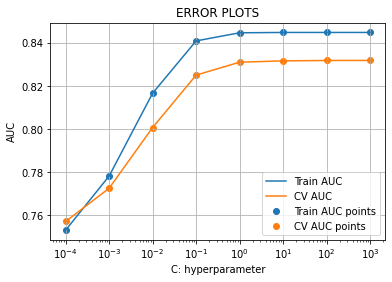

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

"""
y_true : array, shape = [n_samples] or [n_samples, n_classes]
True binary labels or binary label indicators.

y_score : array, shape = [n_samples] or [n_samples, n_classes]
Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of
decisions (as returned by “decision_function” on some classifiers). 
For binary y_true, y_score is supposed to be the score of the class with greater label.

"""

train_auc = []
cv_auc = []
C_list = [0.0001, 0.001 ,0.01 ,0.1, 1, 10, 100, 1000] # list of various inverse of lambda values we want to compare.
for i in tqdm(C_list): # for each values of C_list (i)
    lr = LogisticRegression(C=i,class_weight='balanced', random_state=17, solver = 'liblinear') # initialize Logistic Model with C = i
    lr.fit(X_train, y_train) # fit the lr model on the train data
    y_train_pred = batch_predict(lr, X_train) # Predict on the train data    
    y_cv_pred = batch_predict(lr, X_cv) # Predict on cross validation data
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(C_list, train_auc, label='Train AUC')
plt.plot(C_list, cv_auc, label='CV AUC')
plt.xscale('log') # change the scale of x axis
plt.autoscale(True)
plt.scatter(C_list, train_auc, label='Train AUC points')
plt.scatter(C_list, cv_auc, label='CV AUC points')
plt.xscale('log')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

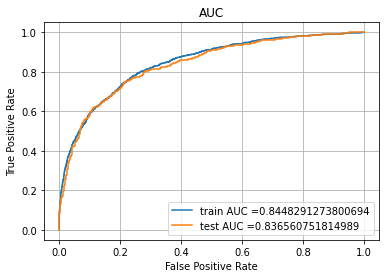

Logistic Regression - Test AUC:  0.836560751814989


In [27]:
# Best Parameter -- C
best_c = 10

# fit best logistic regression model with C = 10
best_lr = LogisticRegression(C=best_c,class_weight='balanced', random_state=17, solver = 'liblinear')

best_lr.fit(X_train,y_train)

from sklearn.metrics import roc_curve, auc


y_train_pred = batch_predict(best_lr, X_train)    
y_test_pred = batch_predict(best_lr, X_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

train_auc_lr = auc(train_fpr, train_tpr)
test_auc_lr = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(train_auc_lr))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(test_auc_lr))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC")
plt.grid()
plt.show()

print("Logistic Regression - Test AUC: ",test_auc_lr)

## Logistic Regression Feature importances

    > In Logistic Regression when the absolute weights are large then w.T*x is also large. 

    > Weights of the feature indicate their importance. 

In [28]:
result = pd.DataFrame()
result['Weights'] = best_lr.coef_[0]
result['Abs_Weights'] = abs(best_lr.coef_[0])
result['Features'] = list(X_train.columns)
result = result.sort_values('Abs_Weights', ascending=False)

result

,Weights,Abs_Weights,Features
15,-5.567203,5.567203,multi_products
12,-2.543283,2.543283,creditscore_age_ratio_log
5,2.352321,2.352321,NumOfProducts
20,1.474438,1.474438,Germany
7,-1.005711,1.005711,IsActiveMember
0,0.949018,0.949018,CreditScore
11,0.769292,0.769292,creditscore_age_ratio
2,-0.733009,0.733009,Age
16,0.698971,0.698971,Valuable_customer
1,-0.605772,0.605772,Gender


From the absolute weights we can see features like 'multi_products','creditscore_age_ratio_log','NumOfProducts','Germany', 'IsActiveMember' are most important and features like 'HasCrCard','Balance', and 'balance_salary_ratio' are least important. 

So feature engineering has helped alot.

Let's drop the least important features and build the model again.

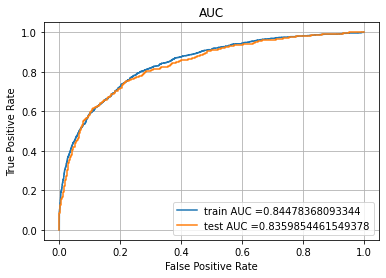

Logistic Regression - Test AUC:  0.8359854461549378


In [29]:
X_train_imp = X_train.drop(['HasCrCard','Balance','balance_salary_ratio'],axis = 1)
X_test_imp = X_test.drop(['HasCrCard','Balance','balance_salary_ratio'],axis = 1)

lr_imp = LogisticRegression(C=best_c,class_weight='balanced', random_state=17, solver = 'liblinear')

lr_imp.fit(X_train_imp,y_train)

y_train_pred = batch_predict(lr_imp, X_train_imp)    
y_test_pred = batch_predict(lr_imp, X_test_imp)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

train_auc_lr = auc(train_fpr, train_tpr)
test_auc_lr = auc(test_fpr, test_tpr)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(train_auc_lr))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(test_auc_lr))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC")
plt.grid()
plt.show()

print("Logistic Regression - Test AUC: ",test_auc_lr)

In [30]:
y_test_predicted = [1 if i > 0.5 else 0 for i in y_test_pred]


Confusion matrix: Train data


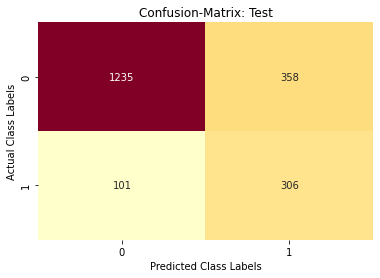

In [31]:
from sklearn.metrics import confusion_matrix
cm_te = confusion_matrix(y_test, y_test_predicted)
import seaborn as sns
# Reference: https://seaborn.pydata.org/generated/seaborn.heatmap.html
# Confusion matrix on train data
print()
print("Confusion matrix: Train data")
ax= plt.subplot()
sns.heatmap(cm_te,annot=True,fmt='1g',cbar = False,cmap = 'YlOrRd')
ax.set_xlabel('Predicted Class Labels');
ax.set_ylabel('Actual Class Labels');
ax.set_title('Confusion-Matrix: Test');
plt.show()


Here we have used 0.5 as threshold. We can also try for different thersholds to find the best one.

In [37]:
## Classification report
from sklearn.metrics import classification_report
cr = classification_report(y_test,y_test_predicted)
print(cr)

              precision    recall  f1-score   support

           0       0.92      0.78      0.84      1593
           1       0.46      0.75      0.57       407

    accuracy                           0.77      2000
   macro avg       0.69      0.76      0.71      2000
weighted avg       0.83      0.77      0.79      2000



In [38]:
from prettytable import PrettyTable

pt = PrettyTable(['Model','Hyper parameter','Auc on testset'])
pt.add_row(['Logistic Regression','1/λ or C = 10',test_auc_lr])
print(pt)


+---------------------+-----------------+--------------------+
|        Model        | Hyper parameter |   Auc on testset   |
+---------------------+-----------------+--------------------+
| Logistic Regression |  1/λ or C = 10  | 0.8359854461549378 |
+---------------------+-----------------+--------------------+


## Save model

save the model + one hot encoder + standard scaler in one pickle file

refer: https://stackoverflow.com/questions/42350635/how-can-you-pickle-multiple-objects-in-one-file

In [40]:
import pickle

with open("model_logit.pickle","wb") as f:
    pickle.dump(ohe, f)
    pickle.dump(sc, f)
    pickle.dump(lr_imp, f)

print("Files Saved!")
"""
# we should read them in the same order as we dumped.
with open("model_logit.pickle", "rb") as f:
    ohe = pickle.load(f)
    sc = pickle.load(f)
    lr_model = pickle.load(f)
"""

Files Saved!


'\n# we should read them in the same order as we dumped.\nwith open("model_logit.pickle", "rb") as f:\n    ohe = pickle.load(f)\n    sc = pickle.load(f)\n    lr_model = pickle.load(f)\n'

In [41]:
# columns used to build model
X_train_imp.columns.tolist()

['CreditScore',
 'Gender',
 'Age',
 'Tenure',
 'NumOfProducts',
 'IsActiveMember',
 'EstimatedSalary',
 'balance_or_not',
 'creditscore_age_ratio',
 'creditscore_age_ratio_log',
 'Better_Age_Credit',
 'Better_Age_Credit_Active',
 'multi_products',
 'Valuable_customer',
 'tenure_age_ratio',
 'high_salary_age',
 'France',
 'Germany',
 'Spain']